TODO:
Learn to use visualization techniques to study:
1. missing data
2. distributions
3. correlation heatmaps
4. pairplots,
5. t-SNE

pre-proc:
1. use catboost for categoric data

model: 


In [65]:
%run ../../EfratPack.ipynb

# JET House Prices Prediction 

# instruction
## Part 1:
[Model submission is done through Kaggle]
Part 1 - EDA
1. Which 3 features have the highest number of missing values
2. How the price behave over the years?
3. Plot the the feature distribution using histograms
4. Compute and order the features by their correlation with label
5. Add more EDA that will help you understand the data and support your modeling decisions

Part 2 - baseline
1. Train the simplest baseline model possible
2. submit your baseline results and share the results

## Part 2:
[Model submission is done through Kaggle]
Your solution:  go wild and build the best performing model!Which model you choose and why (relate to relevant EDA)?
Choose a validation creation process, why you choose it? what is the baseline performance?
Which smart tricks you used to boost your model performance?
Describe potential generalization issues (e.g. overfit/underfit)? How can you handle these?
submit your model and improve your rank in the leaderboard!

Deliverables
A final submission and score of you team in the leaderboard
Working and easy to follow notebook with the 3 parts completed and that produce your best submission.
Slides explaining your project: 
1. EDA
2. decision made
3. feature analysis
4. validation
5. modeling
6. etc



# Imports and loadings

In [34]:
#import tensorflow as tf
#import tensorflow_decision_forests as tfdf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

## Load the dataset


In [40]:
test_file_path = "project/test.csv"
testset_df = pd.read_csv(test_file_path)
train_file_path = "project/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full test set shape is {}".format(testset_df.shape))
print("Full train dataset shape is {}".format(dataset_df.shape))

Full test set shape is (1459, 80)
Full train dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

In [41]:
dataset_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


* There are 79 feature columns. Using these features the model will predict the house sale price indicated by the label column named `SalePrice`.

We will drop the `Id` column as it is not necessary for model training.

In [42]:
id_file = testset_df['Id']
testset_df = testset_df.drop('Id', axis=1)
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


# EDA
## basic info

We can inspect the types of feature columns using the following code:

In [5]:
dataset_df.info(max_cols=79)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 80 entries, MSSubClass to SalePrice
dtypes: float64(3), int64(34), object(43)
memory usage: 912.6+ KB


## House Price Distribution

Now let us take a look at how the house prices are distributed.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
50%      163000.000000
max      755000.000000
Name: SalePrice, dtype: float64


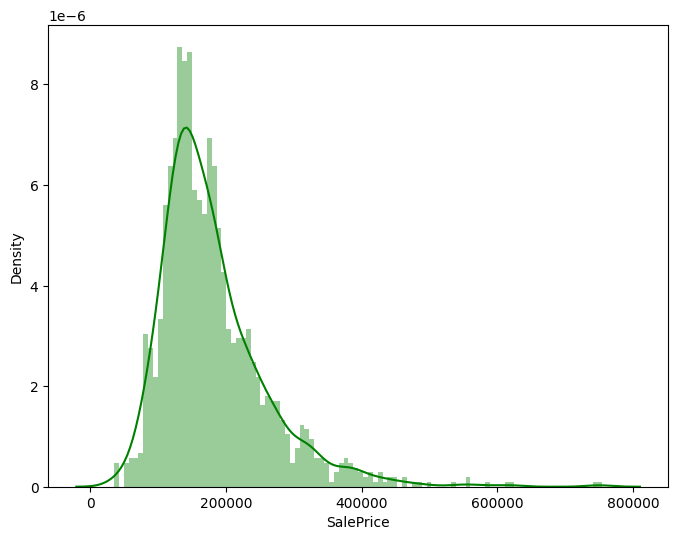

In [6]:
print(dataset_df['SalePrice'].describe(percentiles=[.50]))
plt.figure(figsize=(8, 6))
sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [7]:
list(set(dataset_df.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [8]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let us plot the distribution for all the numerical features.

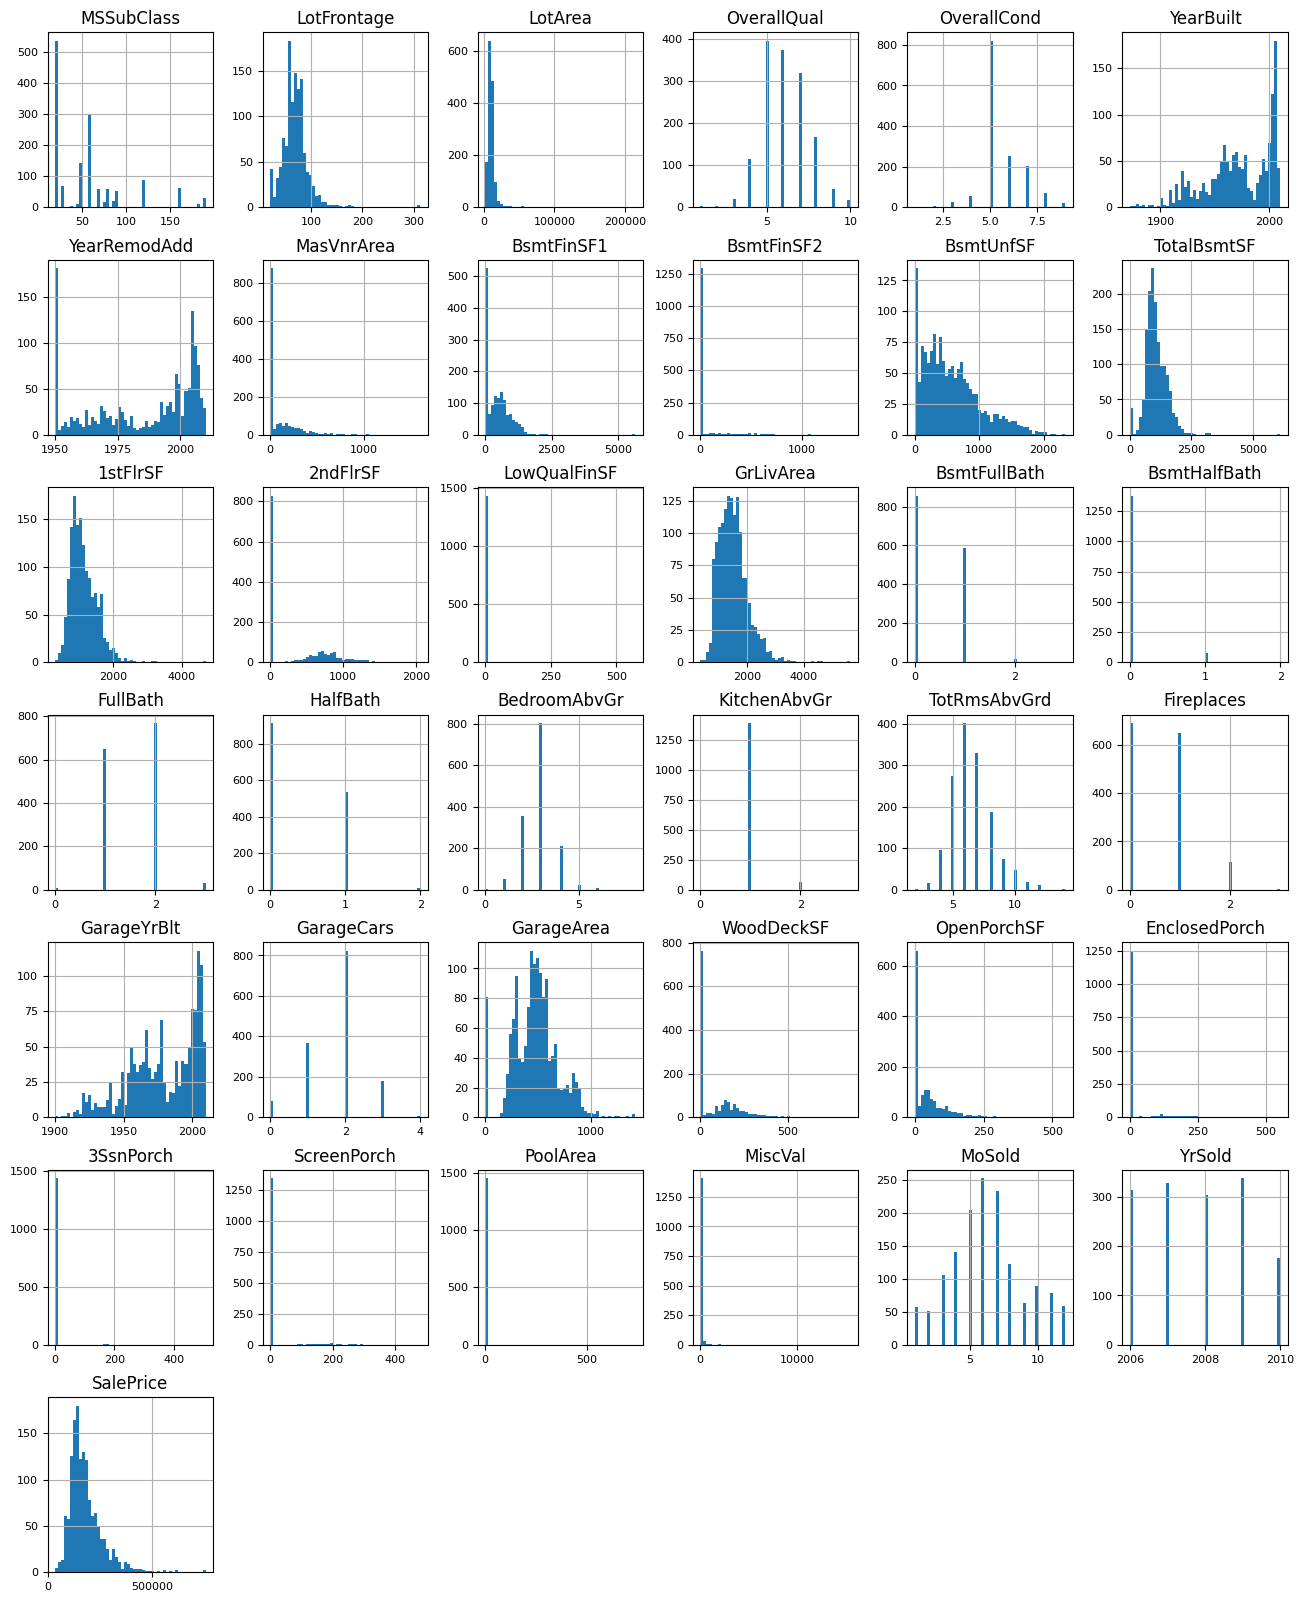

In [9]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Some of these features are discrete while some are continuous. The meaning of the features varies according to context, such as years or quality grade, and some are just numeric measurements like sizes. Some of these features are mostly single variables

## correlations

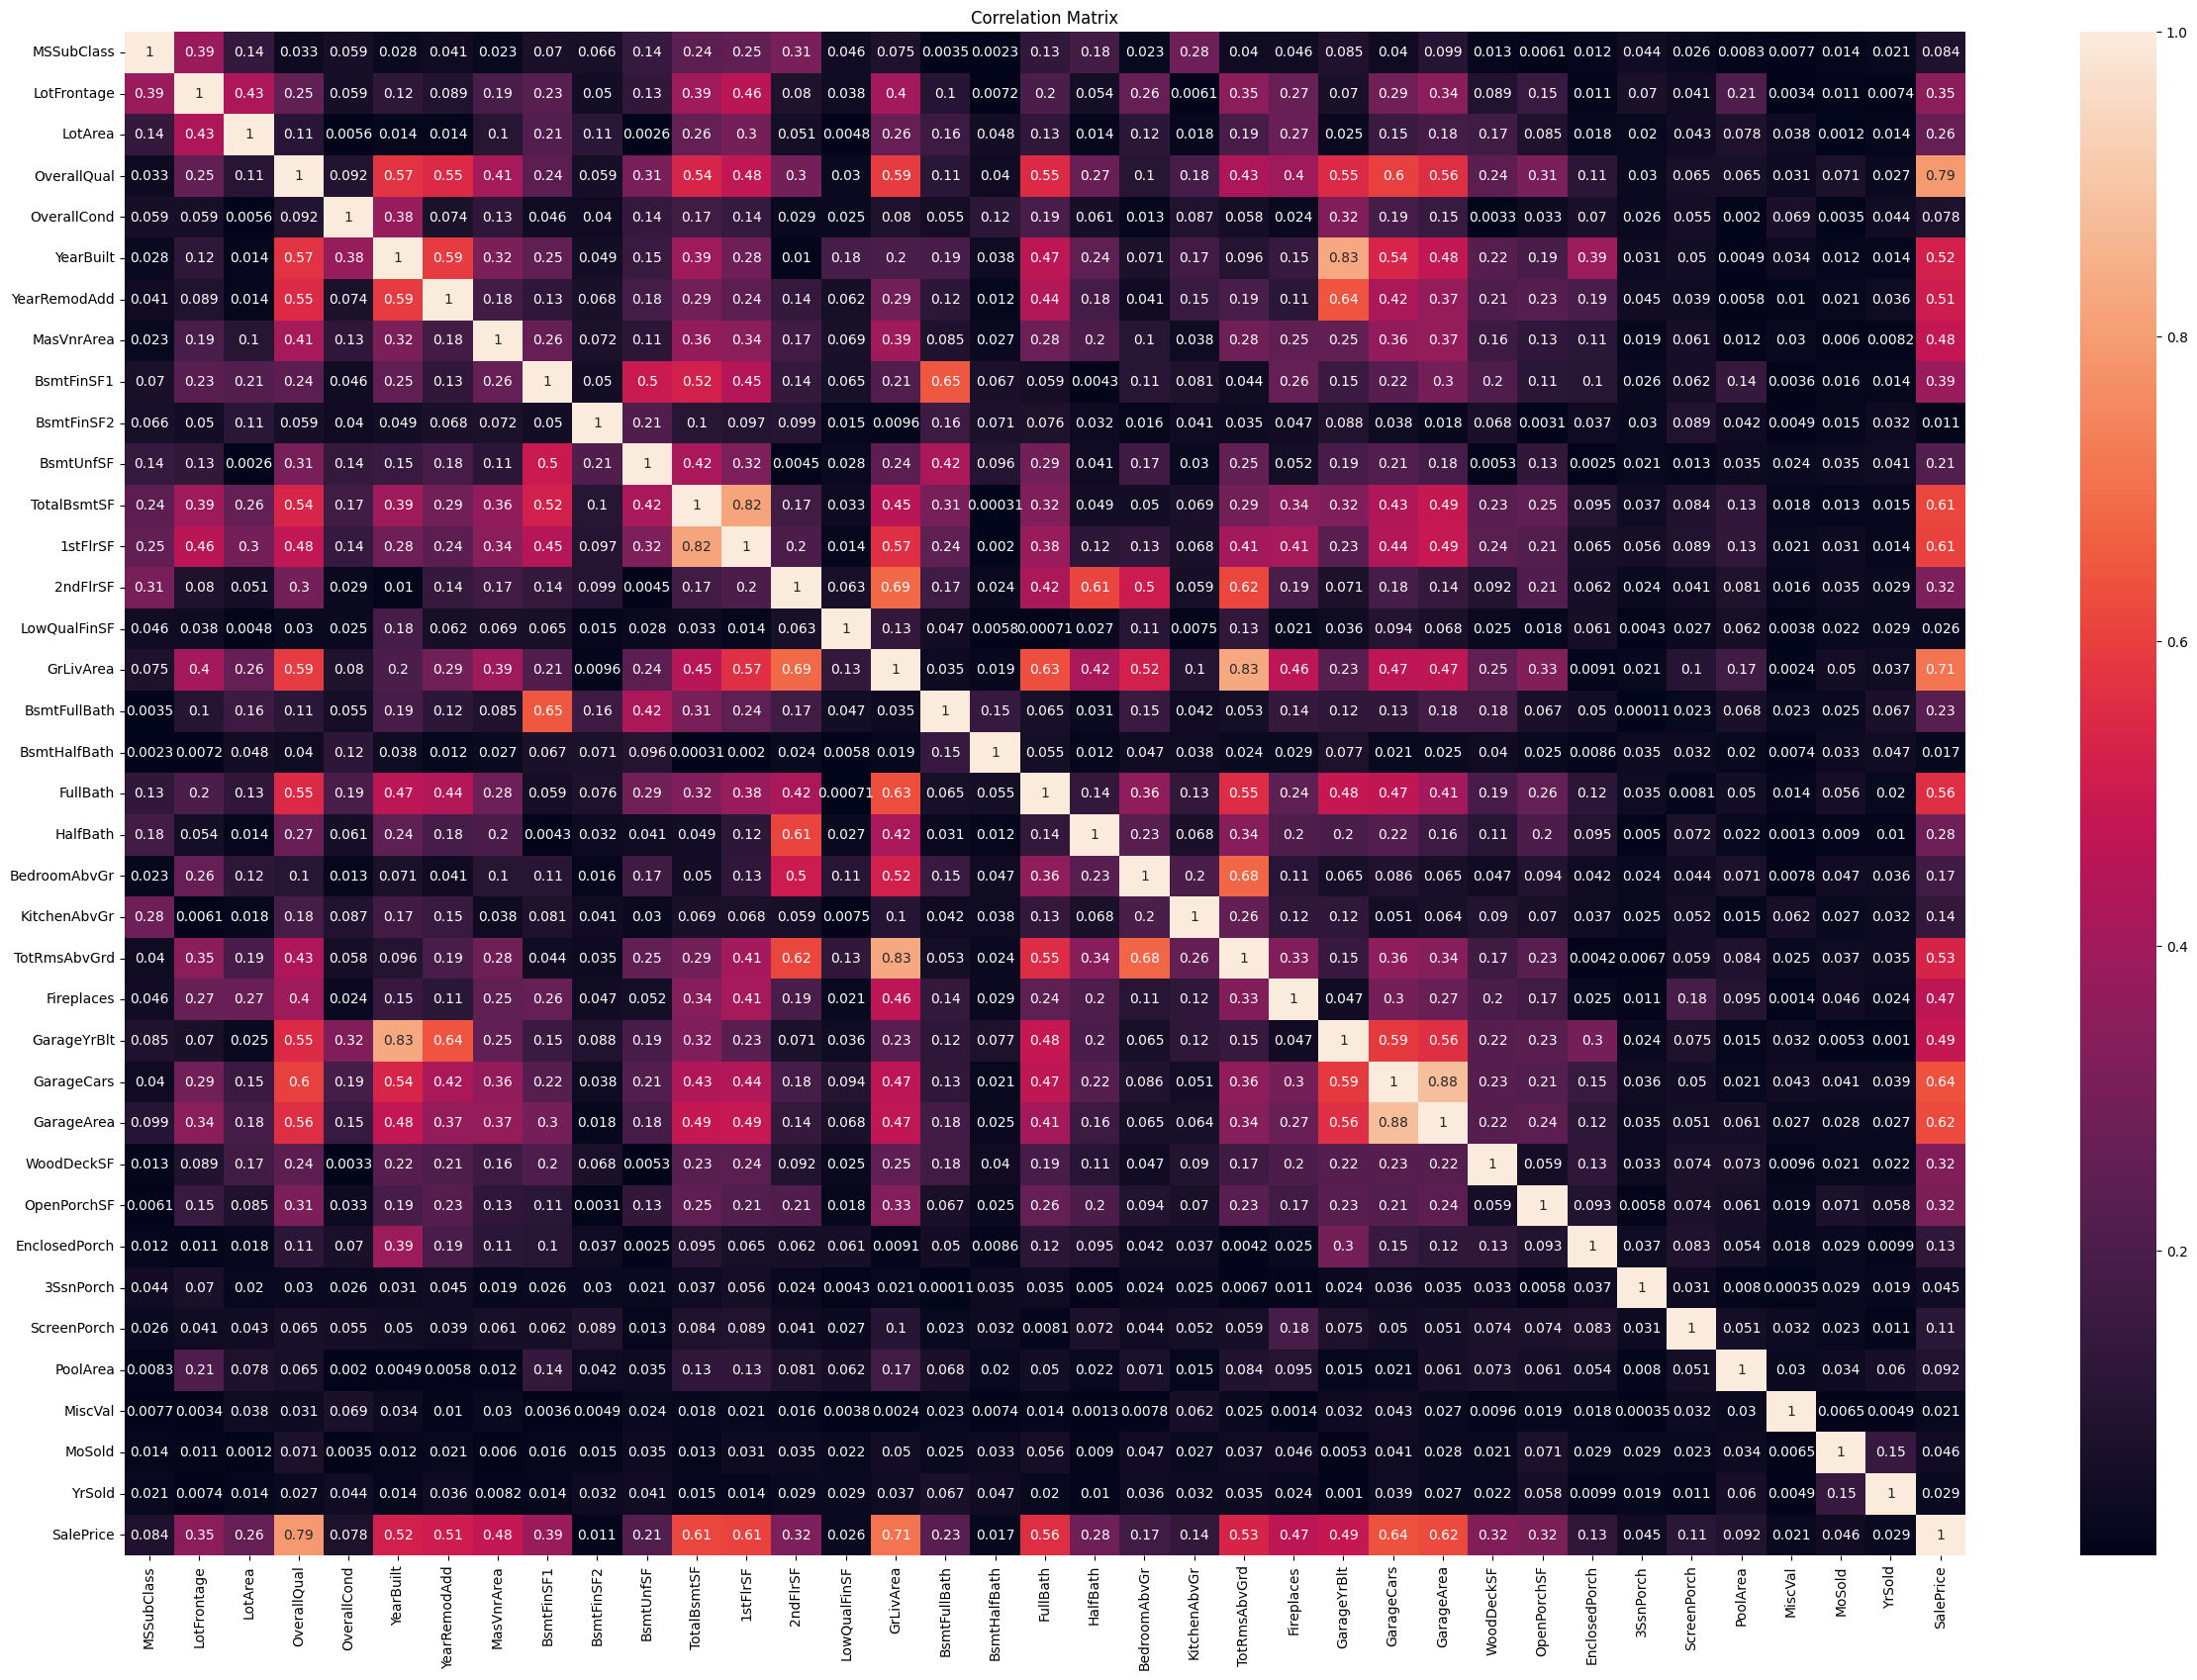

In [10]:
# Correlation Matrix in Numeric Columns
#correlation_matrix = dataset_df.corr(numeric_only=True)
correlation_matrix = abs(df_num.corr())
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

Some of the features are highly correlated with each other; for example, year built and garage year built are 0.85 correlated. This implies that one of them might be less important for the prediction once we have the second.

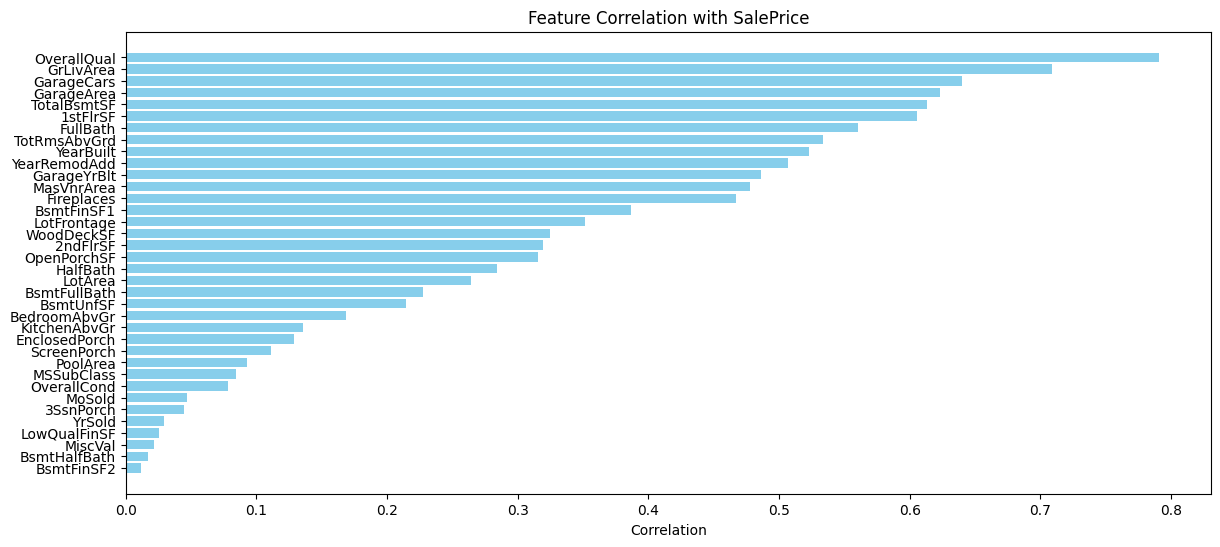

In [11]:
DF = abs(correlation_matrix.iloc[-1]).sort_values(ascending=False)[1:]
# Now let's plot the DataFrame
plt.figure(figsize=(14, 6))
plt.barh(DF.index, DF.values, color='skyblue')
plt.xlabel('Correlation')
plt.title('Feature Correlation with SalePrice')
plt.gca().invert_yaxis()  # To display the highest value at the top
plt.show()


In [12]:
print('most correlated features')
abs(correlation_matrix.iloc[-1]).sort_values(ascending=False).head(6)[1:]


most correlated features


OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64

We can see a list of most correlated features (out of the numeric features) with the sale price, that )gives us the first impression about their importance

In [13]:
df_Obj = dataset_df.select_dtypes(include = ['O'])
df_Obj.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


## sale_price_per_year

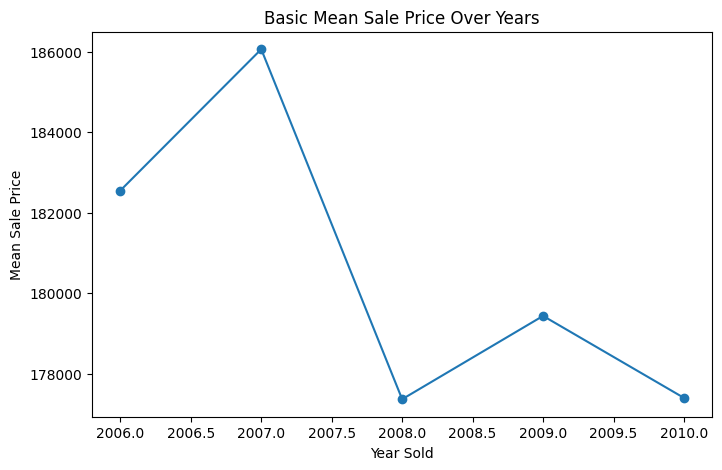

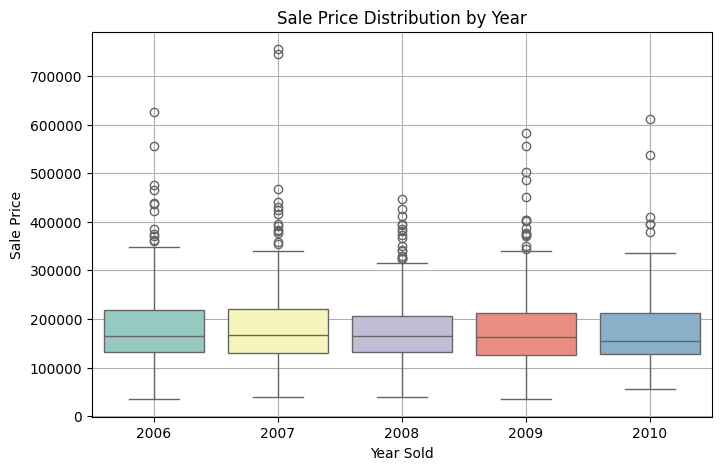

Also, the mean sale price seems affected by year; when zooming out, it seems negligible relative to the price diversity, so overall no year dependency.


In [14]:
mean_sale_price_per_year = dataset_df.groupby('YrSold')['SalePrice'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.plot(mean_sale_price_per_year['YrSold'], mean_sale_price_per_year['SalePrice'], marker='o', linestyle='-')
plt.title('Basic Mean Sale Price Over Years')
plt.xlabel('Year Sold')
plt.ylabel('Mean Sale Price')
plt.show()
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex=True)
# Boxplot on the second subplot
sns.boxplot(x='YrSold', y='SalePrice', data=dataset_df, ax=axs, palette="Set3")
axs.set_title('Sale Price Distribution by Year')
axs.set_xlabel('Year Sold')
axs.set_ylabel('Sale Price')
axs.grid(True)
plt.show()

print('Also, the mean sale price seems affected by year; when zooming out, it seems negligible relative to the price diversity, so overall no year dependency.')

We have a lot of categorical features, they need to be treated or preprocessed correctly. Alternatively, we can use the CatBoost algorithm or other algorithms that handle categorical features directly
## check NAs and remove them
### check NAs On Col

In [15]:
nan_counts  = dataset_df.isna().sum().sort_values(ascending=False).head(20)/len(dataset_df)*100
print(f"features with the highest number of missing values in %")
print(f"{nan_counts}%")

features with the highest number of missing values in %
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtCond         2.534247
BsmtQual         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
MSSubClass       0.000000
dtype: float64%


Features with high nan_counts are not quality enough, and we would like to filter them out from the database

In [52]:
# Filter columns where the count of NaNs is greater than X%
Config_params = dict()
Config_params['nan_counts_threshold'] = 15
Config_params['filter_out_HighNA'] = 1
if Config_params['filter_out_HighNA']:
    nan_counts_threshold = Config_params['nan_counts_threshold']
    features_with_HighNA = nan_counts[nan_counts > nan_counts_threshold].index.tolist()
    print(f"filter out list:{features_with_HighNA}")
    testset_df_DropHighNA = testset_df.drop(columns=features_with_HighNA)
    dataset_df_DropHighNA = dataset_df.drop(columns=features_with_HighNA)
    print(f" new shape after dropping features_with_HighNA {dataset_df_DropHighNA.shape}")

filter out list:['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 'LotFrontage']
 new shape after dropping features_with_HighNA (1460, 73)


### check NAs On rows

In [55]:
# Calculate the percentage of NaN values in each row
row_nan_counts = dataset_df_DropHighNA.isna().sum(axis=1) 
top_row_nan_counts = row_nan_counts.sort_values(ascending=False)
print("number of Rows with missing values:")
print(top_row_nan_counts.value_counts())

print("it seems that most of rows with missing values misses exacly 5 values")

#------------------------------
# Filter the rows with NA
rows_with_missing_values = dataset_df_DropHighNA[row_nan_counts >0]
unique_missing_column_groups = set()
# Iterate through rows and identify unique groups of missing columns
for _, row in rows_with_missing_values.iterrows():
    # Extract groups of 5 columns
    groups = tuple(row.index[row.isna()])
    # Add the unique group to the set
    unique_missing_column_groups.add(groups)

# Sort the unique groups by their length
sorted_unique_missing_column_groups = sorted(unique_missing_column_groups, key=lambda x: len(x))
# Print the unique groups of 5 missing columns
print('\nmissing values groups:')
for i, group in enumerate(sorted_unique_missing_column_groups, start=1):
    print(f"Group {i} of {len(group)} missing columns: {group}")

#------------------------------
# Find all feature columns that contain 'Bsmt' in their names
print()
Garage_features = [col for col in dataset_df_DropHighNA.columns if 'Garage' in col]
Bsmt_features = [col for col in dataset_df_DropHighNA.columns if 'Bsmt' in col]
#print(f"Features containing 'Garage':{Garage_features}")
#print(f"Features containing 'Bsmt':{Bsmt_features}")

TotalBsmtSFVal = dataset_df_DropHighNA[dataset_df_DropHighNA['BsmtQual'].isna()]['TotalBsmtSF'].unique()
GarageAreaVal = dataset_df_DropHighNA[dataset_df_DropHighNA['GarageType'].isna()]['GarageArea'].unique()
print('we can see that when basement featurs has na when their is no basment (TotalBsmtSF=0) and the same goes for Garage features (GarageArea=0)')
#print(dataset_df_DropHighNA[dataset_df_DropHighNA['TotalBsmtSF']==0]['BsmtQual'].unique())
#print(dataset_df_DropHighNA[dataset_df_DropHighNA['GarageArea']==0]['GarageType'].unique())

print('we will replace all those valuse with a value NotExist')      
basement_list = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
Garage_list = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
['BsmtFinType2','BsmtExposure']
['Electrical']
['MasVnrArea']

# Replace NaN values in the specified columns for rows where 'TotalBsmtSF' is equal to 0 with 'NotExist'
dataset_df_DropHighNA.loc[dataset_df_DropHighNA['TotalBsmtSF'] == 0, basement_list] = dataset_df_DropHighNA.loc[dataset_df_DropHighNA['TotalBsmtSF'] == 0, basement_list].fillna('NotExist')
dataset_df_DropHighNA.loc[dataset_df_DropHighNA['GarageArea'] == 0, Garage_list] = dataset_df_DropHighNA.loc[dataset_df_DropHighNA['GarageArea'] == 0, Garage_list].fillna('NotExist')
testset_df_DropHighNA.loc[testset_df_DropHighNA['TotalBsmtSF'] == 0, basement_list] = testset_df_DropHighNA.loc[testset_df_DropHighNA['TotalBsmtSF'] == 0, basement_list].fillna('NotExist')
testset_df_DropHighNA.loc[testset_df_DropHighNA['GarageArea'] == 0, Garage_list] = testset_df_DropHighNA.loc[testset_df_DropHighNA['GarageArea'] == 0, Garage_list].fillna('NotExist')

print("Now we are left with only 11 missing values, and we will imput them")

# Your provided list for basement-related columns
dataset_df_DropHighNA['BsmtFinType2'].fillna('NotExist', inplace=True)
dataset_df_DropHighNA['BsmtExposure'].fillna('NotExist', inplace=True)
electrical_mode = dataset_df_DropHighNA['Electrical'].mode()[0]
dataset_df_DropHighNA['Electrical'].fillna(electrical_mode, inplace=True)
mas_vnr_area_mean = dataset_df_DropHighNA['MasVnrArea'].mean()
dataset_df_DropHighNA['MasVnrArea'].fillna(mas_vnr_area_mean, inplace=True)

# Your provided list for basement-related columns
testset_df_DropHighNA['BsmtFinType2'].fillna('NotExist', inplace=True)
testset_df_DropHighNA['BsmtExposure'].fillna('NotExist', inplace=True)
testset_df_DropHighNA['Electrical'].fillna(electrical_mode, inplace=True)
testset_df_DropHighNA['MasVnrArea'].fillna(mas_vnr_area_mean, inplace=True)

#print again:
print("\nfinally we remain without na at all:")
row_nan_counts = dataset_df_DropHighNA.isna().sum(axis=1) 
top_row_nan_counts = row_nan_counts.sort_values(ascending=False)
print("number of Rows with missing values:")
print(top_row_nan_counts.value_counts())


number of Rows with missing values:
0    1460
Name: count, dtype: int64
it seems that most of rows with missing values misses exacly 5 values

missing values groups:

we can see that when basement featurs has na when their is no basment (TotalBsmtSF=0) and the same goes for Garage features (GarageArea=0)
we will replace all those valuse with a value NotExist
Now we are left with only 11 missing values, and we will imput them

finally we remain without na at all:
number of Rows with missing values:
0    1460
Name: count, dtype: int64


# PreProccess

In [56]:
# Assuming 'dataset_df' is your DataFrame
y = dataset_df_DropHighNA['SalePrice']
X = dataset_df_DropHighNA.drop('SalePrice', axis=1)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X = X_train.select_dtypes(include = ['float64', 'int64'])
y = y_train
X_t = X_test.select_dtypes(include = ['float64', 'int64'])
y_t = y_test



# Basic Model

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [80]:
Config_params["Model"]='CatBoost' #'decisionTree','CatBoost'

In [81]:
if Config_params["Model"]=='decisionTree':
    # Initializing and fitting the Decision Tree Regressor
    decision_tree = DecisionTreeRegressor(random_state=42)
    decision_tree.fit(X, y)
    y_pred = decision_tree.predict(X_t)

In [82]:
if Config_params["Model"]=='CatBoost':
    
    # Initialize the CatBoost Regressor
    catboost_regressor = CatBoostRegressor(random_seed=42, silent=True)
    
    # Fit the model
    catboost_regressor.fit(X, y)
    
    # Make predictions
    y_pred = catboost_regressor.predict(X_t)


In [83]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_t, y_pred)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 26597.895742060227


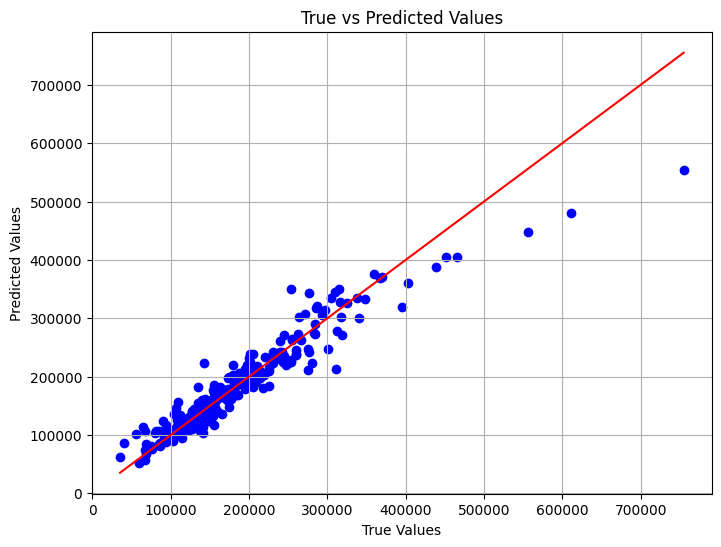

In [84]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_t, y_pred, color='blue')
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_t), max(y_t)], [min(y_t), max(y_t)], color='red') # Line for perfect predictions
plt.grid(True)
plt.show()

# Submission
Finally predict on the competition test data using the model.

In [88]:
X_file = testset_df_DropHighNA
X_file_num = X_file.select_dtypes(include = ['float64', 'int64'])

if Config_params["Model"]=='decisionTree':
    y_pred = decision_tree.predict(X_file_num)
if Config_params["Model"]=='CatBoost':
    y_pred = catboost_regressor.predict(X_file_num)
    

# Assuming 'dataset_df' is your DataFrame

output = pd.DataFrame({'Id': id_file,
                       'SalePrice': y_pred.squeeze()})
output.to_csv('./project/submission_V1_CatBoost.csv', index=False)
output.head()

,Id,SalePrice
0,1461,126924.442639
1,1462,165183.331521
2,1463,187847.089457
3,1464,191263.130562
4,1465,193990.731151


In [89]:
#sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
#sample_submission_df['SalePrice'] = rf.predict(test_ds)
#sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
output.to_csv('./project/submission.csv', index=False)
output.head()

,Id,SalePrice
0,1461,126924.442639
1,1462,165183.331521
2,1463,187847.089457
3,1464,191263.130562
4,1465,193990.731151
